# Covid19 query-mapping DEMO

In [ ]:
import sys
sys.path.append("../")
from concerto_function5_3 import *


In [ ]:
import numpy as np
import concerto_function5_3 as conc
import scanpy as sc
import pandas as pd

import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go
from matplotlib import rc_context

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from statannot import add_stat_annotation
cm = 1/2.54

def plot_subcluster_proportion(selected_cells, cell_type_col_name = 'prediction',group_col_name = 'group',
            sample_col_name = 'sample', n_col_per_row=4, width=8,height=6):
    '''
        input: 
            selected_cells = ega[ega.obs['l1_pred']=='CD8 T'], 
            cell_type_col_name: subcluster col name,
            group_col_name: covid status,
            n_col_per_row: ncols of plots
    '''
    cell_types = selected_cells.obs[cell_type_col_name]
    group = selected_cells.obs[group_col_name]
    samples = selected_cells.obs[sample_col_name]
    a = pd.crosstab(cell_types, samples)
    # 每个cluster占该sample的百分比
    clu_prop_df =  a/np.sum(a)

    # prepare visualization dataframe
    clu_prop_df.index = clu_prop_df.index.values.astype(str)
    clu_prop_df.columns = clu_prop_df.columns.astype(str)
    clu_prop_df['subcluster'] = clu_prop_df.index.values.astype(str)
    clu_prop = pd.melt(clu_prop_df,
            id_vars=['subcluster'], 
            var_name='sample', value_name='proportion'
           )
    clu_prop = clu_prop.merge(selected_cells.obs[[sample_col_name,group_col_name]].drop_duplicates(),
                   left_on='sample',right_on=sample_col_name,how='left')
    
    n_row=1;n_col=n_col_per_row
    # order = ["Ctrl", 'Stage1', "Stage2", 'Stage3','Stage4','IAV-Stage1','IAV-Stage3'] # clu_prop[group_col_name].unique()
    order = clu_prop[group_col_name].unique()
    stat_pairs = [("HC", "M"), ("HC", "S"), 
                  ("M", "S")]

    f, axs = plt.subplots(n_row, n_col, figsize=(width*n_col*cm, height*cm))
    for i,c in enumerate(clu_prop['subcluster'].unique()):
        ax_i = axs[int(np.floor(i/n_col)),i%n_col] if n_row>1 else axs[i%n_col]
        g = sns.boxplot(
            data=clu_prop[clu_prop['subcluster']==c], 
            x=group_col_name, y='proportion',
            order = order,linewidth=0.5, fliersize=2,
            ax=ax_i)
        sns.swarmplot(x=group_col_name, y='proportion', data=clu_prop[clu_prop['subcluster']==c],
                      color=".25",size=2.5,order=order, ax=ax_i)
        g.set(ylabel=f'frac',
              title=f'cluster {c}')
        ax_i.tick_params(axis='x', rotation=45)
        ax_i, test_results = add_stat_annotation(ax_i, data=clu_prop[clu_prop['subcluster']==c], 
                                         x=group_col_name, y='proportion', order=order,
                                       box_pairs=stat_pairs,
                                       test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', verbose=0)
    #plt.subplots_adjust(hspace=0.8, wspace=0.5)
    f.tight_layout()
    # f.show()
    return f

In [ ]:
zzm = sc.read_h5ad('./data/zzm_allsample_annotated.h5ad')
zzm.obs['group'] = zzm.obs.sampleID.apply(lambda x:x[2:-3])

In [ ]:
ega = sc.read_h5ad('./data/jonas_adata.h5ad')

In [ ]:
llq = sc.read_h5ad('./data/longqi/llq_covid_0121_annotated.h5ad')


# Generating query embedding
- Model was train by Ren et al. and Zhu et al.; Pretrained weight can be found in pretrained_weightpretrained_weight/
-  Direct inference is performed here.

In [ ]:
ref_embedding, query_embedding,source_data_id,target_data_id = conc.concerto_test_attention_0117(
    model_path= './pretrained_weight/',
      query_tf_path ='./query_tf/',
      ref_tf_path = './ref_tf/',
    super_parameters = {'batch_size': 256, 'epoch': 1, 'lr': 1e-5,'drop_rate': 0.1})

# Umap visualization
(~ 5 min)

In [ ]:
sid = pd.Series(source_data_id)
llq_idx = sid[sid.isin(llq.obs_names)].index
zzm_idx = sid[sid.isin(zzm.obs_names)].index
qid = pd.Series(target_data_id)
ega_id = qid[qid.isin(ega.obs_names)].index
target_data_id = qid[ega_id]
query_embedding = query_embedding[ega_id,:]

adata_mapping = sc.AnnData(
    X=np.concatenate([ref_embedding[zzm_idx,:], ref_embedding[llq_idx,:],query_embedding])
)
sc.pp.neighbors(adata_mapping, use_rep='X')
sc.tl.umap(adata_mapping)

In [ ]:
df_r_q2 = pd.concat([zzm[sid[zzm_idx]].obs,llq[sid[llq_idx]].obs,ega[target_data_id].obs])
df_r_q2.loc[sid[zzm_idx],:] = df_r_q2.loc[sid[zzm_idx],:].fillna('Ren et al')
df_r_q2.loc[sid[llq_idx],:] = df_r_q2.loc[sid[llq_idx],:].fillna('Zhu et al')
df_r_q2.loc[target_data_id,:] = df_r_q2.loc[target_data_id,:].fillna('query')
df_r_q2['set'] =  ['Ren et al']*zzm_idx.shape[0] + ['Zhu et al']*llq_idx.shape[0] + ['query']*ega_id.shape[0]
df_r_q2['x'] = adata_mapping.obsm['X_umap'][:,0]
df_r_q2['y'] = adata_mapping.obsm['X_umap'][:,1]

In [ ]:
adata_mapping.obs=df_r_q2

... storing 'cellName' as categorical
... storing 'sampleID' as categorical
... storing 'celltype' as categorical
... storing 'majorType' as categorical
... storing 'group' as categorical
... storing 'orig.ident' as categorical
... storing 'batch' as categorical
... storing 'cell_type' as categorical
... storing 'Stage' as categorical
... storing 'disease' as categorical
... storing 'gender' as categorical
... storing 'sample' as categorical
... storing 'cell_type_1' as categorical
... storing 'set' as categorical


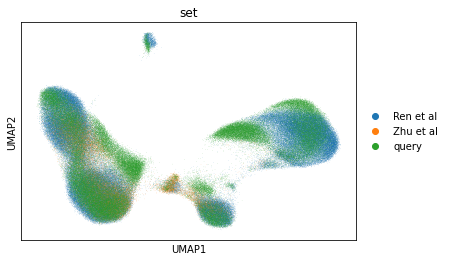

Trying to set attribute `.obs` of view, copying.
... storing 'nCount_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'nFeature_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'percent.mt' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'seurat_clusters' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'integrated_snn_res.0.8' as categorical


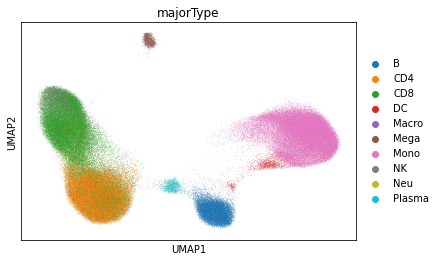

Trying to set attribute `._uns` of view, copying.


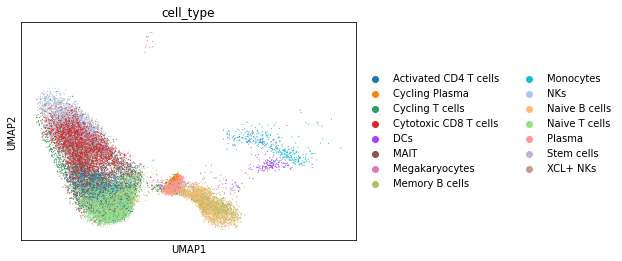

Trying to set attribute `.obs` of view, copying.
... storing 'nCount_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'nFeature_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'percent.mt' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'nCount_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'nFeature_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'nCount_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'nFeature_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'nCount_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'nCount_RNA' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copyin

In [ ]:

# with rc_context({'svg.fonttype':'none',
#     "font.size":5.5,
#     'axes.labelsize': 5.5,
#     'axes.titlesize':6,
#     'legend.fontsize': 5,
#     'ytick.labelsize':5,
#     'xtick.labelsize':5, 
#      'figure.dpi':150}):
sc.pl.umap(adata_mapping, color=['set'])
sc.pl.umap(adata_mapping[adata_mapping.obs['set']=='Ren et al'], color=['majorType'])
sc.pl.umap(adata_mapping[adata_mapping.obs['set']=='Zhu et al'], color=['cell_type'])
# sc.pl.umap(adata_mapping[adata_mapping.obs['set']=='ega'], color=['set'], save='_query_batch.png') 

## Annotation

###  hierarchical Annotation

In [ ]:
ega_pred = ega[target_data_id].copy()
ega_pred.obsm['embedding'] = query_embedding
ega_pred.obsm['X_umap'] = adata_mapping.obs.loc[target_data_id,['x','y']]

Level1 annotation (major Type)

In [ ]:
nn_ = 25
pred_label_zzmL1, conf_zzmL1 = conc.knn_classifier_faiss(ref_embedding[zzm_idx,:], query_embedding,
                        zzm, sid[zzm_idx], 'majorType',nn_, num_chunks=100)
ega_pred.obs['pred_zzm_L1'] = pred_label_zzmL1

In [ ]:
zzm_ref = zzm[sid[zzm_idx]].copy()
zzm_ref.obsm['embedding'] = ref_embedding[zzm_idx,:]
zzm_ref.obsm['X_umap'] = adata_mapping.obs.loc[sid[zzm_idx],['x','y']]

Level2 annotation (subtype)

In [ ]:
nn_ = 25
for l1 in zzm_ref.obs['majorType'].unique():
    mask_zzm = zzm_ref.obs['majorType'] == l1
    mask_ega = ega_pred.obs['pred_zzm_L1'] == l1
    pred_label_zzmL2, conf_zzmL2 = conc.knn_classifier_faiss(zzm_ref[mask_zzm].obsm['embedding'], ega_pred[mask_ega].obsm['embedding'],
                            zzm_ref[mask_zzm], zzm_ref[mask_zzm].obs_names, 'celltype',nn_, num_chunks=100)
    ega_pred.obs.loc[mask_ega,'pred_zzm_L2'] = pred_label_zzmL2
    ega_pred.obs.loc[mask_ega,'conf_zzm_L2'] = conf_zzmL2

... storing 'pred_zzm_L1' as categorical
... storing 'pred_zzm_L2' as categorical


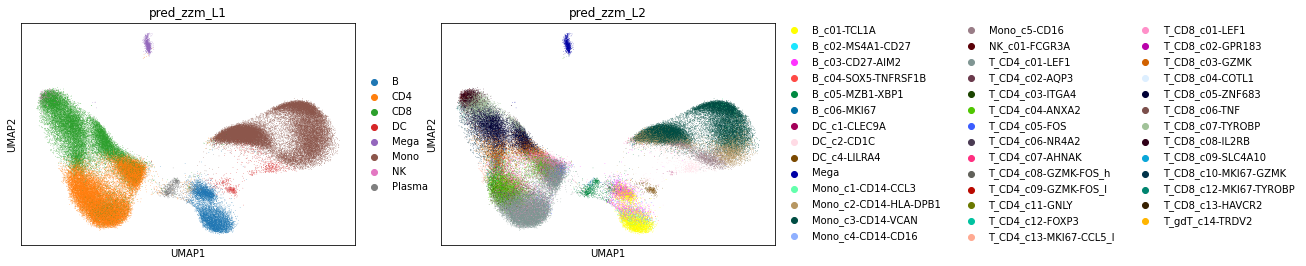

In [ ]:
sc.pl.umap(ega_pred, color=['pred_zzm_L1','pred_zzm_L2'])

### CD8

In [ ]:
mask = ega_pred.obs['pred_zzm_L1']=='CD8'
selected_cells = ega_pred[mask].copy()

In [ ]:
markers = {'naive': ['TCF7','LEF1','SELL','CCR7'],
           'cytotoxic': ['GZMB', 'PRF1', 'GNLY'], 
           'proliferation': ['MKI67', 'TYMS'],
           'exhaustion': ['PDCD1', 'TIGIT', 'LAG3', 'HAVCR2', 'CTLA4'],
           }
sig_score = cal_signature_score(selected_cells,markers)

In [ ]:
a = selected_cells.obs['exhaustion']
function_map_zzm = {'T_CD8_c01-LEF1':'CD8 Naive',
            'T_CD8_c03-GZMK': 'CD8 TEM', 'T_CD8_c05-ZNF683':'CD8 TEM', 'T_CD8_c07-TYROBP':'CD8 TEM', 'T_CD8_c08-IL2RB':'CD8 TEM',
            'T_CD8_c02-GPR183': 'CD8 TCM',
            'T_CD8_c11-MKI67-FOS': 'CD8  proliferating', 'T_CD8_c12-MKI67-TYROBP':'CD8  proliferating',
            'T_CD8_c10-MKI67-GZMK': 'CD8  proliferating',# 'T_CD8_c13-HAVCR2': 'CD8 Tex', 
                   }
selected_cells.obs['pred_l3'] = selected_cells.obs['pred_zzm_L2'].map(function_map_zzm)
selected_cells.obs.loc[((selected_cells.obs['pred_zzm_L2'] == 'T_CD8_c10-MKI67-GZMK') & (a>0.2)),'pred_l3'] = 'CD8 Tex' # proliferating exhausted T
selected_cells.obs.loc[a>0.7,'pred_l3'] = 'CD8 Tex'

Trying to set attribute `.obs` of view, copying.
... storing 'pred_l3' as categorical


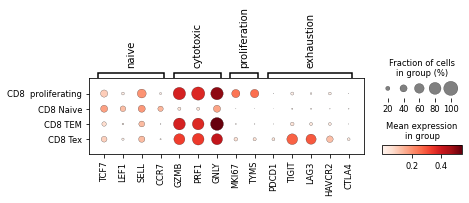

In [ ]:
sc.pl.dotplot(selected_cells[selected_cells.obs['pred_l3']!='CD8 TCM'], markers, 'pred_l3')

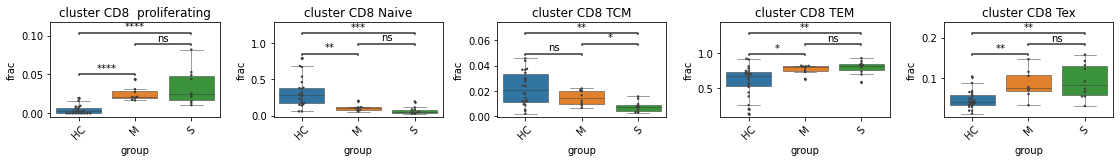

In [ ]:
for l1_cluster in ['CD8']:
    f1 = plot_subcluster_proportion(
        selected_cells=selected_cells,
        cell_type_col_name = 'pred_l3',
        group_col_name = 'group',
        sample_col_name = 'sample',
        n_col_per_row=selected_cells.obs['pred_l3'].nunique())

Trying to set attribute `.obs` of view, copying.
... storing 'pred_l3' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'pred_l4' as categorical


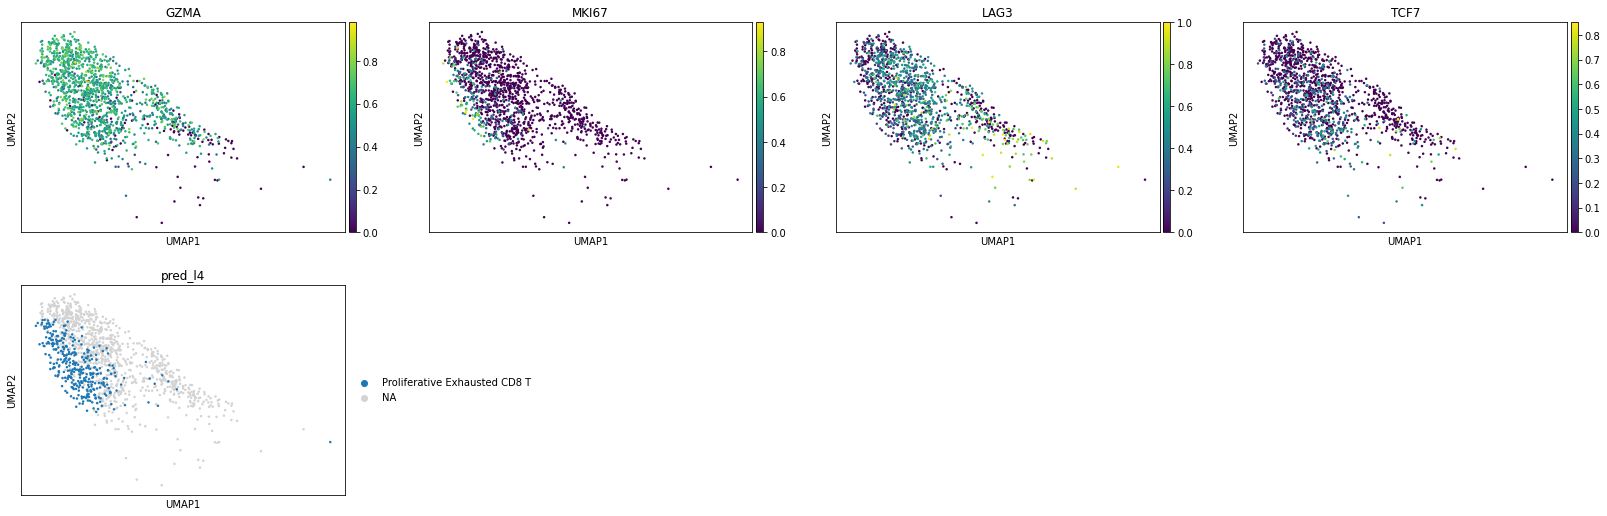

In [ ]:
mask = selected_cells.obs['pred_l3']=='CD8 Tex'
selected_cells.obs.loc[mask& (selected_cells.obs['pred_zzm_L2']=='T_CD8_c10-MKI67-GZMK'),'pred_l4'] = 'Proliferative Exhausted CD8 T'
sc.pl.umap(selected_cells[mask],color=['GZMA','MKI67','LAG3','TCF7','pred_l4'],size=25)

### CD4 T

In [ ]:
nn_ = 25
mask_ega = ega_pred.obs['pred_zzm_L1'] == 'CD4'
pred_label_CD4, conf_CD4 = conc.knn_classifier_faiss(ref_embedding[llq_idx,:], ega_pred[mask_ega].obsm['embedding'],
                        llq, sid[llq_idx], 'cell_type',nn_, num_chunks=100)
ega_pred.obs.loc[mask_ega,'pred_CD4_llq'] = pred_label_CD4
ega_pred.obs.loc[mask_ega,'conf_CD4_llq'] = conf_CD4

In [ ]:
mask = ega_pred.obs['pred_zzm_L1']=='CD4'
selected_cells = ega_pred[mask].copy()

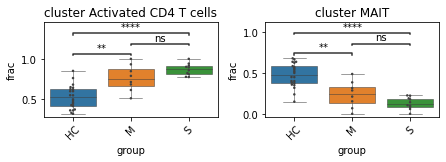

In [ ]:
for l1_cluster in ['CD4']:
    f1 = plot_subcluster_proportion(
        selected_cells=selected_cells[selected_cells.obs['pred_CD4_llq'].isin(['Activated CD4 T cells','MAIT'])],
        cell_type_col_name = 'pred_CD4_llq',
        group_col_name = 'group',
        sample_col_name = 'sample',
        n_col_per_row=2)

In [ ]:
mask = selected_cells.obs['pred_CD4_llq']=='Activated CD4 T cells'
selected_cells[mask,:]

View of AnnData object with n_obs × n_vars = 1292 × 46584
    obs: 'cell_type', 'disease', 'gender', 'group', 'sample', 'cell_type_1', 'pred_zzm_L1', 'pred_zzm_L2', 'conf_zzm_L2', 'pred_CD4_llq', 'conf_CD4_llq'
    uns: 'pred_zzm_L1_colors', 'pred_zzm_L2_colors'
    obsm: 'embedding', 'X_umap'

In [ ]:
expr = selected_cells[mask,['CD2AP','TNFSF14']].X.toarray()
df_expr = selected_cells[mask].obs.copy()
df_expr['CD2AP'] = expr[:,0]
df_expr['TNFSF14'] = expr[:,1]

a = {j:i for i,j in df_expr[['group','sample']].values}
df2 = pd.DataFrame(df_expr.groupby(by='sample')['CD2AP','TNFSF14'].apply(np.mean))
df2['group'] = df2.index.map(a)

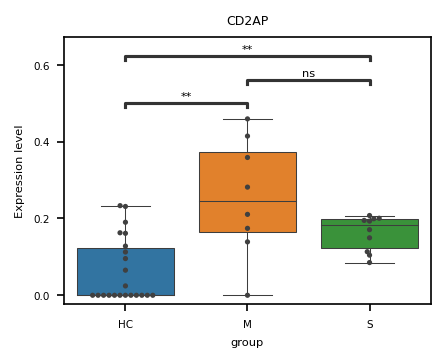

In [ ]:
order = ["HC", "M", "S"] # clu_prop[group_col_name].unique()
stat_pairs = [("HC", "M"), ("HC", "S"), 
              ("M", "S")]

with rc_context({'svg.fonttype':'none',
    "font.size":5.5,
    'axes.labelsize': 5.5,
    'axes.titlesize':6,
    'legend.fontsize': 5,
    'ytick.labelsize':5,
    'xtick.labelsize':5, 'figure.dpi':150,
     'figure.figsize':(8*cm,6*cm)}):
    f, axs = plt.subplots(1, 1,figsize=(8*cm, 6*cm))

    g = sns.boxplot(
        data=df2, 
        x='group', y='CD2AP',
        order = order,linewidth=0.5, fliersize=2,
        ax=axs)
    sns.swarmplot(x='group', y='CD2AP', data=df2,
                  color=".25",size=2.5,order=order, ax=axs)
    g.set(ylabel=f'Expression level',
          title=f'CD2AP')
    # ax_i.tick_params(axis='x', rotation=45)
    ax_i, test_results = add_stat_annotation(axs, data=df2, 
                                     x='group', y='CD2AP', order=order,
                                   box_pairs=stat_pairs,
                                   test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', verbose=0)

### Mono

In [ ]:
mask = ega_pred.obs['pred_zzm_L1']=='Mono'
selected_cells = ega_pred[mask].copy()

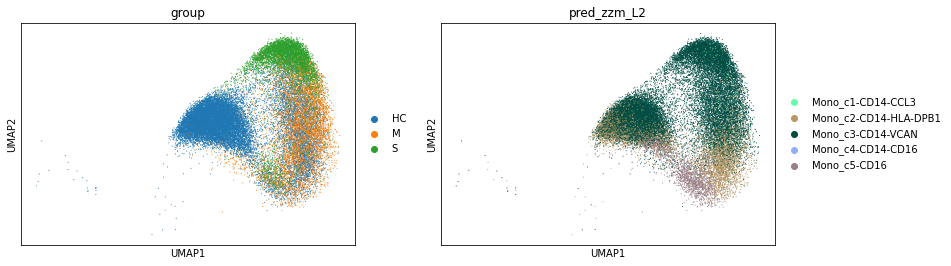

In [ ]:
sc.pl.umap(selected_cells, color=['group','pred_zzm_L2'])

In [ ]:
function_map_zzm = {
    'Mono_c3-CD14-VCAN': 'CD14 Mono', 'Mono_c2-CD14-HLA-DPB1': 'CD14 Mono', 'Mono_c1-CD14-CCL3':'CD14 Mono', 
    'Mono_c5-CD16': 'CD16 Mono', 
                   }
selected_cells.obs['pred_l3'] = selected_cells.obs['pred_zzm_L2'].map(function_map_zzm)

... storing 'pred_l3' as categorical


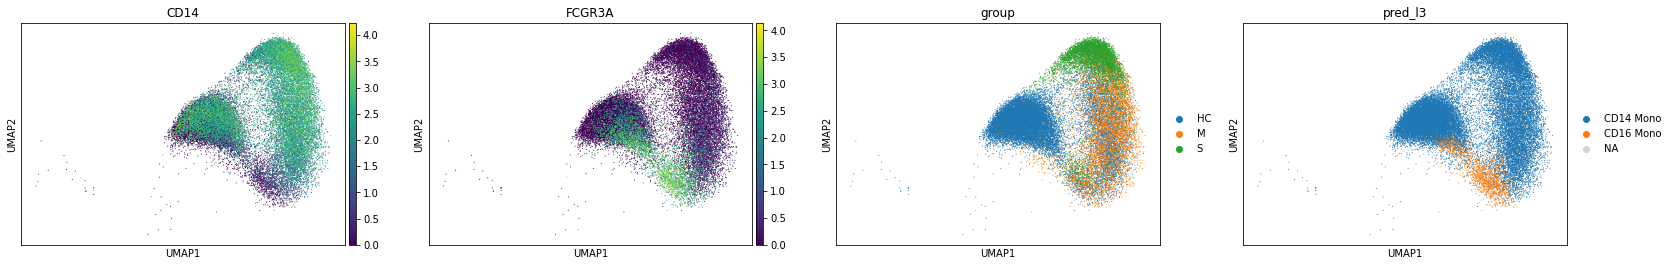

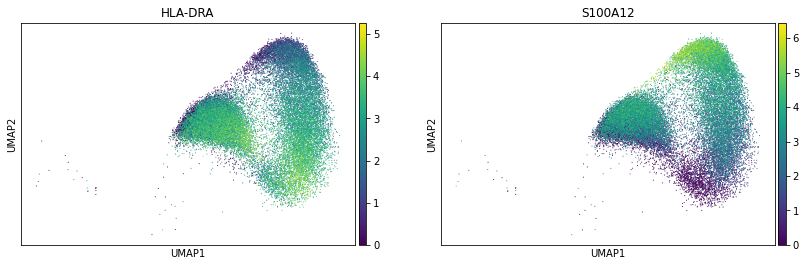

In [ ]:
sc.pl.umap(selected_cells, color=['CD14','FCGR3A', 'group','pred_l3'])
sc.pl.umap(selected_cells, color=['HLA-DRA','S100A12'])    